### Imports

In [1]:
%load_ext autoreload
%autoreload 2
#%matplotlib notebook
%matplotlib inline

In [2]:
# Computational packages
import numpy as np
import matplotlib.pyplot as plt
import torch
import tqdm

# General packages
import datetime
import sys
import os

# custom packages
import ratsimulator
from ratsimulator.Environment import Rectangle
import spatial_maps as sm # CINPLA spatial maps

# avoid adding multiple relave paths to sys.path
sys.path.append("../../src") if "../../src" not in sys.path else None 
from PlaceCells import PlaceCells
from Models import SorscherRNN
from Experiment import Experiment
from methods import *
from datahandling import *

### Setup Experiment

In [3]:
experiment = Experiment(name = '12CL')
if experiment.is_new_experiment:
    """
    MAKE EXPERIMENTAL CHANGES HERE
    """
    experiment.params['nepochs'] = 3000
    experiment.params['sampler'] = "CLSampler"
    # init default environments
    for i in range(1,12):
        experiment.environments.append(ratsimulator.Environment.Rectangle(boxsize=(2.2, 2.2), soft_boundary=0.03))
        # init default agents
        experiment.agents.append(
            ratsimulator.Agent(
                environment=experiment.environments[i],
                angle0=None,
                p0=None,
                dt=0.02,
                turn_angle=5.76 * 2,
                b=0.13 * 2 * np.pi,
                mu=0,
                boundary_mode="sorschers",
            )
        )
        # init default place cell ensembles
        experiment.pc_ensembles.append(
            PlaceCells(
                environment=experiment.environments[i],
                npcs=experiment.params["Np"],
                pc_width=0.12,
                DoG=True,
                surround_scale=2,
                p=2.0,
                seed=i,
            )
        )

experiment.setup()

Experiment <12CL> is NEW. Loading DEFAULT experiment settings!
Singular matrix
Singular matrix
Default <params>, <environments>, <agents> and <pc_ensembles> can now be changed. Finish setup by calling setup()
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Creating directories
Saving experiment details


True

In [4]:
# detach experiment specifics
params = experiment.params
environments = experiment.environments
agents = experiment.agents
pc_ensembles = experiment.pc_ensembles
paths = experiment.paths

num_workers = 30
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"{device=}")

device=device(type='cuda')


### Initialise objects

In [5]:
# Initialise data loading
num_samples = params['nsteps'] * params['batch_size'] # * params['nepochs']
dataset = Dataset(agents = agents, pc_ensembles = pc_ensembles, num_samples = num_samples, **params)
datasampler = eval(params['sampler'])(num_environments = len(environments), num_samples = num_samples, \
                                      num_epochs = params['nepochs'])
dataloader = torch.utils.data.DataLoader(dataset, batch_size=params['batch_size'], sampler = datasampler, num_workers=num_workers)

# Initialise model
model = SorscherRNN(pc_ensembles, Ng=params['Ng'], Np=params['Np'])
model.to(device)
print(f"{model = }")

# Initialise optimizer (use custom weight decay, rather than torch optim decay)
optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'], betas=(0.9, 0.999), \
                             eps=1e-08, weight_decay=0.0, amsgrad=False)

model = SorscherRNN(
  (init_position_encoder): Linear(in_features=512, out_features=4096, bias=False)
  (RNN): RNN(2, 4096, bias=False, batch_first=True)
  (decoder): Linear(in_features=4096, out_features=512, bias=False)
)


### Train/Load Model

In [6]:
loss_history = []
training_metrics = {}
checkpoint_filenames = filenames(paths['checkpoints'])

if checkpoint_filenames:
    # load model latest (wrt. #epochs trained)
    print(f"Loading model at epoch = {checkpoint_filenames[-1]}")
    checkpoint = torch.load(paths['checkpoints'] / checkpoint_filenames[-1])
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    loss_history = checkpoint['loss_history']
    training_metrics = checkpoint['training_metrics']
    print("Loaded weights")
    
    if isinstance(datasampler, CLSampler):
        datasampler.epoch_counter = len(loss_history)
    
# whether to train
if train:=True:
    loss_history, training_metrics = model.train(trainloader = dataloader, optimizer = optimizer, weight_decay=params['weight_decay'], \
                               nepochs=params['nepochs'], checkpoint_path = paths['checkpoints'], \
                               loss_history = loss_history, training_metrics = training_metrics)
    # (re)load checkpoint strs and latest checkpoint
    checkpoint_filenames = filenames(paths['checkpoints'])
    checkpoint = torch.load(paths['checkpoints'] / checkpoint_filenames[-1])

Epoch=2999/3000, loss=6.159938282966614, decoding_error(pred/true)=0.045223355703055856/0.0422883091121912: 100%|██████████| 3000/3000 [5:32:45<00:00,  6.66s/it]     


## **Analyse Model**
### Training history

Maximum Entropy possible: 6.2383246250395095


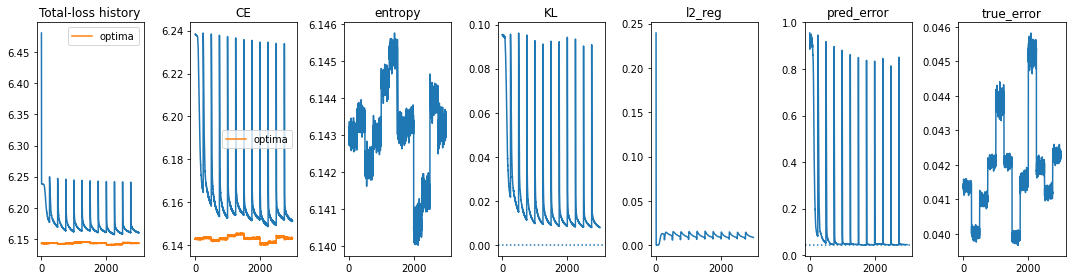

In [7]:
fig, ax = plt.subplots(ncols=len(training_metrics) + 1,figsize=(15,4))
ax[0].plot(loss_history)
ax[0].plot(training_metrics['entropy'], label='optima')
ax[0].set_title('Total-loss history')
ax[0].legend()

for i,(key,value) in enumerate(training_metrics.items()):
    ax[i+1].plot(value)
    ax[i+1].set_title(key)
    if key == 'KL':
        ax[i+1].axhline(0,ls=":")
    if key == 'pred_error':
        ax[i+1].axhline(np.mean(training_metrics['true_error']),ls=":")
    if key == 'CE':
        ax[i+1].plot(training_metrics['entropy'], label='optima')
        ax[i+1].legend()

plt.tight_layout()

# maximum labelled distribution entropy (uniform labelled distribution)
n = 512
px = np.ones(n) / n # uniform
entropy = lambda x: -np.sum(x * np.log(x))
print(f"Maximum Entropy possible: {entropy(px)}")

### Create ratemaps

In [8]:
def ratemap_trajectories(dataset, environment_idx, num_trajectories=1500):
    """Generate trajectories to compute ratemaps with (scipy.stats.binned_statistics_2d)"""
    batch_velocities, batch_init_pc_positions, batch_positions = [], [], []
    for _ in range(num_trajectories):
        (velocities, init_pc_positions), _, positions, _ = dataset[environment_idx]
        batch_velocities.append(velocities)
        batch_init_pc_positions.append(init_pc_positions)
        batch_positions.append(positions)
    batch_inputs = [torch.stack(batch_velocities), torch.stack(batch_init_pc_positions)]
    batch_positions = torch.stack(batch_positions).detach().numpy()
    x = np.ravel(batch_positions[:,1:,0])
    y = np.ravel(batch_positions[:,1:,1])
    return batch_inputs, x, y

# mec_idxs = slice(0, params['Ng'], 1)
res = np.array([32, 32])
for env_i in range(len(environments)):
    print(f"Creating ratemaps for environment_idx = {env_i+1}/{len(environments)}")
    # create list of missing ratemaps - to be created
    ratemaps_filenames = filenames(paths["ratemaps"] / f"env_{env_i}")
    ratemaps_filenames = [ratemaps_filename.split('.')[0] for ratemaps_filename in ratemaps_filenames]
    missing_ratemaps_filenames = list(set(checkpoint_filenames) - set(ratemaps_filenames))
    missing_ratemaps_filenames.sort()
    if not missing_ratemaps_filenames:
        continue
    
    # generate trajectories to compute ratemaps for
    batch_inputs, x, y = ratemap_trajectories(dataset, environment_idx=env_i, num_trajectories=1500)
    
    # loop all saved model weights - and create ratemaps
    for checkpoint_epoch in tqdm.tqdm(missing_ratemaps_filenames):
        epoch_ratemaps_path = paths["ratemaps"] / f"env_{env_i}" / (checkpoint_epoch + ".pkl")
        
        # load model weights, forward (to g) and compute ratemaps
        checkpoint = torch.load(paths['checkpoints'] / checkpoint_epoch)
        model.load_state_dict(checkpoint['model_state_dict'])
        activities = model.g(batch_inputs).detach().cpu().numpy()
        activities = activities.reshape(-1, activities.shape[-1]).T
        ratemaps = scipy.stats.binned_statistic_2d(x, y, activities, bins=res)[0]
        
        # save ratemaps
        with open(epoch_ratemaps_path, "wb") as f:
            pickle.dump(ratemaps,f)

Creating ratemaps for environment_idx = 1/12


100%|██████████| 301/301 [12:41<00:00,  2.53s/it]


Creating ratemaps for environment_idx = 2/12


100%|██████████| 301/301 [11:29<00:00,  2.29s/it]


Creating ratemaps for environment_idx = 3/12


100%|██████████| 301/301 [10:13<00:00,  2.04s/it]


Creating ratemaps for environment_idx = 4/12


100%|██████████| 301/301 [10:24<00:00,  2.08s/it]


Creating ratemaps for environment_idx = 5/12


100%|██████████| 301/301 [10:27<00:00,  2.08s/it]


Creating ratemaps for environment_idx = 6/12


100%|██████████| 301/301 [10:41<00:00,  2.13s/it]


Creating ratemaps for environment_idx = 7/12


100%|██████████| 301/301 [10:27<00:00,  2.08s/it]


Creating ratemaps for environment_idx = 8/12


100%|██████████| 301/301 [10:27<00:00,  2.09s/it]


Creating ratemaps for environment_idx = 9/12


100%|██████████| 301/301 [10:25<00:00,  2.08s/it]


Creating ratemaps for environment_idx = 10/12


100%|██████████| 301/301 [10:27<00:00,  2.09s/it]


Creating ratemaps for environment_idx = 11/12


100%|██████████| 301/301 [10:31<00:00,  2.10s/it]


Creating ratemaps for environment_idx = 12/12


100%|██████████| 301/301 [10:23<00:00,  2.07s/it]


### Load ratemaps

In [9]:
env_i = 0
latest_ratemaps_path = paths["ratemaps"] / f"env_{env_i}" / (checkpoint_filenames[-1] + ".pkl")
with open(latest_ratemaps_path, "rb") as f:
    ratemaps = pickle.load(f)
print("Loaded ratemaps")

Loaded ratemaps


### Example ratemaps (unsorted)

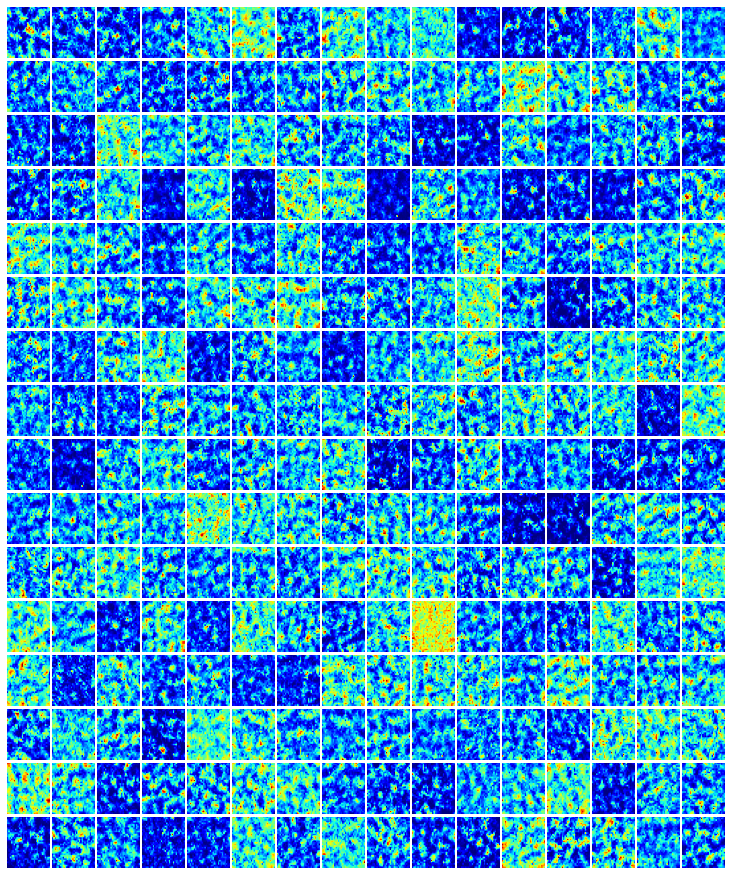

In [10]:
start_idx = 256*1
num_ratemaps = 256
fig, ax = multiimshow(ratemaps[start_idx:start_idx+num_ratemaps])

### Grid score ratemaps (only last model checkpoint)

In [11]:
def score_ratemaps(ratemaps, env_i, checkpoint_filename):
    # if grid scores have already been calculate and saved to disk, load these (FAST!)
    #score_map_path = paths["grid_scores"] / (checkpoint_filenames[-1] + f"_env_{env_i}.pkl")
    score_map_path = paths["grid_scores"] / (checkpoint_filename + f"_env_{env_i}.pkl")
    if os.path.exists(score_map_path):
        print(os.path.split(score_map_path)[-1], "already exists. Loading score map.")
        with open(score_map_path, "rb") as f:
            score_map = pickle.load(f)
        return score_map
    
    # BANINO (and Sorscher) grid scoring method
    from scores import GridScorer
    res = np.array([32,32])
    starts = [0.2] * 10
    ends = np.linspace(0.4, 1.0, num=10)
    box_width, box_height = environments[env_i].boxsize
    coord_range=((environments[env_i].origo[0], box_width), (environments[env_i].origo[0], box_height))
    coords_range=((-box_width/2, box_width/2), (-box_height/2, box_height/2))
    mask_parameters = zip(starts, ends.tolist())
    scorer = GridScorer(nbins=res[0], coords_range=coords_range, mask_parameters=mask_parameters)

    # score ratemaps (Could use NUMBA for faster computations?)
    score_map = np.zeros(params['Ng']) # ratemap score lookup table
    for i in tqdm.trange(params['Ng']):
        # interpolated_ratemap = interpolate_missing_pixels(ratemaps[i], np.isnan(ratemaps[i]))
        # score_map[i] = sm.gridness(interpolated_ratemap)
        score_60, score_90, max_60_mask, max_90_mask, sac = scorer.get_scores(ratemaps[i])
        score_map[i] = score_60

    with open(score_map_path, "wb") as f:
        pickle.dump(score_map,f)
    return score_map

# create scores for all ratemaps across all environments
for env_i in range(len(environments)):
    print(f"Calculating grid score for the ratemaps of environment={env_i+1}/{len(environments)}")
    filename_idx = int(((len(checkpoint_filenames) - 1) / len(environments))*(env_i + 1) - 1)
    latest_ratemaps_path_env_i = paths["ratemaps"] / f"env_{env_i}" / (checkpoint_filenames[filename_idx] + ".pkl")
    print(checkpoint_filenames[filename_idx])
    with open(latest_ratemaps_path_env_i, "rb") as f:
        ratemaps_env_i = pickle.load(f)
    score_map = score_ratemaps(ratemaps_env_i, env_i, checkpoint_filenames[filename_idx])

# choose score map
print("hello")
score_map = score_ratemaps(ratemaps, env_i = 0, checkpoint_filename = checkpoint_filenames[filename_idx])

# sort scores and ratemaps
sort_idxs = np.argsort(score_map)[::-1]
sorted_scores = score_map[sort_idxs]

Calculating grid score for the ratemaps of environment=1/12
0240


  0%|          | 0/4096 [00:00<?, ?it/s]/home/users/vemundss/Prosjekter/emergent-grid-cells/notebooks/experiments/../../src/scores.py:141: RuntimeWarning: invalid value encountered in true_divide
  x_coef = np.divide(covar, np.multiply(std_seq1, std_seq2))
100%|██████████| 4096/4096 [02:35<00:00, 26.42it/s]


Calculating grid score for the ratemaps of environment=2/12
0490


100%|██████████| 4096/4096 [02:35<00:00, 26.32it/s]


Calculating grid score for the ratemaps of environment=3/12
0740


100%|██████████| 4096/4096 [02:35<00:00, 26.37it/s]


Calculating grid score for the ratemaps of environment=4/12
0990


100%|██████████| 4096/4096 [02:35<00:00, 26.27it/s]


Calculating grid score for the ratemaps of environment=5/12
1240


100%|██████████| 4096/4096 [02:35<00:00, 26.28it/s]


Calculating grid score for the ratemaps of environment=6/12
1490


100%|██████████| 4096/4096 [02:35<00:00, 26.27it/s]


Calculating grid score for the ratemaps of environment=7/12
1740


100%|██████████| 4096/4096 [02:35<00:00, 26.33it/s]


Calculating grid score for the ratemaps of environment=8/12
1990


100%|██████████| 4096/4096 [02:35<00:00, 26.32it/s]


Calculating grid score for the ratemaps of environment=9/12
2240


100%|██████████| 4096/4096 [02:36<00:00, 26.13it/s]


Calculating grid score for the ratemaps of environment=10/12
2490


100%|██████████| 4096/4096 [02:36<00:00, 26.21it/s]


Calculating grid score for the ratemaps of environment=11/12
2740


100%|██████████| 4096/4096 [02:36<00:00, 26.22it/s]


Calculating grid score for the ratemaps of environment=12/12
2990


100%|██████████| 4096/4096 [02:36<00:00, 26.21it/s]


hello


100%|██████████| 4096/4096 [02:35<00:00, 26.32it/s]


### Example ratemaps (sorted)

Text(0.5, 0.98, 'gc_score = 1.1444260602925014 -- 0.6840827340801297')

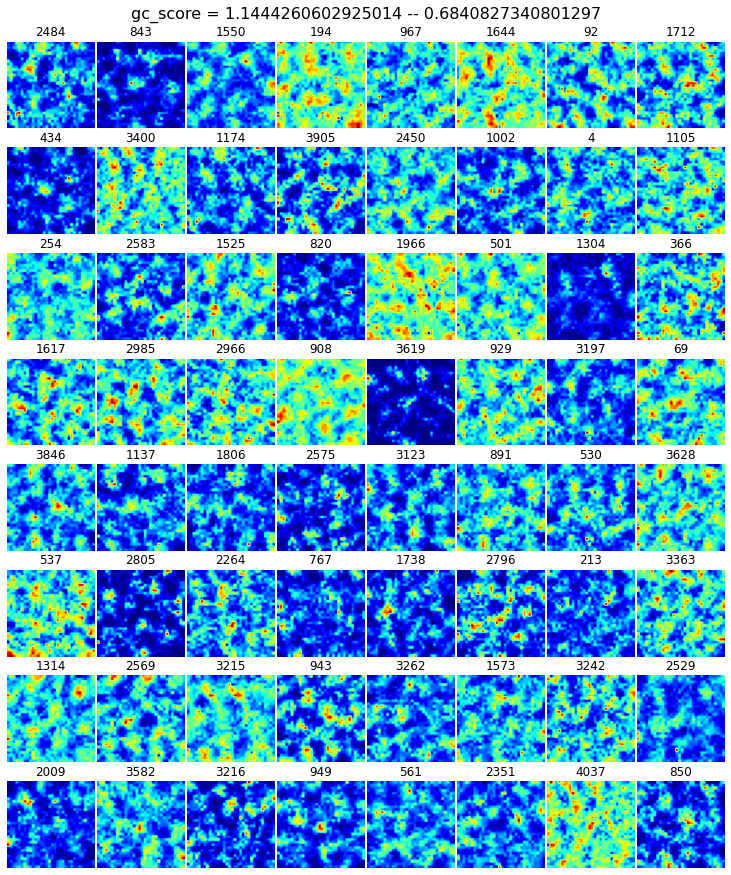

In [12]:
start_idx = 0
num_ratemaps = 2**6
fig, axs = multiimshow(ratemaps[sort_idxs][start_idx:start_idx+num_ratemaps], titles=sort_idxs[start_idx:start_idx+num_ratemaps])
fig.suptitle(f"gc_score = {sorted_scores[start_idx]} -- {sorted_scores[start_idx+num_ratemaps]}", fontsize=16)

### Create grid cell ratemap dynamics (grid cell emergence video)

In [ ]:
from dynamics import RatemapDynamics
for env_i in range(len(environments)):
    print(f"Creating grid dynamics for the ratemaps of environment={env_i+1}/{len(environments)}")
    
    # concatenating ratemaps
    ratemap_dynamics = []
    print("Loading ratemaps")
    for checkpoint_epoch in tqdm.tqdm(checkpoint_filenames):
        with open(paths["ratemaps"] / f"env_{env_i}" / (checkpoint_epoch + ".pkl"), "rb") as f:
            # load and sort ratemaps wrt. grid score
            ratemap_dynamics.append(pickle.load(f)[sort_idxs])
    ratemap_dynamics = np.stack(ratemap_dynamics, axis=0)
    
    # creating videos from ratemaps
    num_gc_in_video = 64
    num_videos = params['Ng'] // num_gc_in_video
    print("Creating videos")
    for gcs_i in tqdm.trange(0, num_videos):
        idxs = slice(gcs_i * num_gc_in_video, (gcs_i + 1) * num_gc_in_video)
        if os.path.exists(paths["dynamics"] / f"env_{env_i}" / f'{idxs.start}-{idxs.stop - 1}.mp4'):
            continue
        ratemap_video = RatemapDynamics(ratemap_dynamics[:,idxs], sorted_scores[idxs], sort_idxs[idxs], epochs = checkpoint_filenames)
        ratemap_video.animation.save(paths["dynamics"] / f"env_{env_i}" / f'{idxs.start}-{idxs.stop - 1}.mp4')

Creating grid dynamics for the ratemaps of environment=1/12
Loading ratemaps


100%|██████████| 301/301 [00:36<00:00,  8.28it/s]


Creating videos


 31%|███▏      | 20/64 [1:29:38<3:16:49, 268.41s/it]/home/users/vemundss/Prosjekter/emergent-grid-cells/notebooks/experiments/../../src/dynamics.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self.fig, self.axs = plt.subplots(
100%|██████████| 64/64 [4:49:04<00:00, 271.01s/it]  


Creating grid dynamics for the ratemaps of environment=2/12
Loading ratemaps


100%|██████████| 301/301 [00:32<00:00,  9.14it/s]


Creating videos


100%|██████████| 64/64 [4:56:55<00:00, 278.36s/it]  


Creating grid dynamics for the ratemaps of environment=3/12
Loading ratemaps


100%|██████████| 301/301 [00:37<00:00,  7.98it/s]


Creating videos


100%|██████████| 64/64 [4:54:20<00:00, 275.95s/it]  


Creating grid dynamics for the ratemaps of environment=4/12
Loading ratemaps


100%|██████████| 301/301 [00:38<00:00,  7.83it/s]


Creating videos


100%|██████████| 64/64 [4:55:00<00:00, 276.57s/it]  


Creating grid dynamics for the ratemaps of environment=5/12
Loading ratemaps


100%|██████████| 301/301 [00:45<00:00,  6.63it/s]


Creating videos


 89%|████████▉ | 57/64 [4:22:56<32:13, 276.14s/it]  

### Predicted place Cells (with(out) SOFTMAX)

In [ ]:
"""
forward_with_softmax = lambda x: torch.exp(model(x, log_softmax=True))
ratemaps = compute_ratemaps(model=model, dataset=dataset, num_trajectories=1250, res=res, idxs=idxs)[0]
fig, ax = multiimshow(ratemaps)
"""

In [ ]:
model.prune_mask = list(range(int(4096/2),4096)) # set prune mask
model.prune_mask = [] # reset prune mask
model.prune_mask

In [ ]:
idxs=slice(0, 16**2, 1)
res=np.array([32, 32])
ratemaps = compute_ratemaps(model=model.g, dataset=dataset, num_trajectories=1250, res=res, idxs=idxs)[0]
fig, ax = multiimshow(ratemaps)

### Decoding labels and predictions to cartesian

In [ ]:
environment_idx = 0
[[vel, init_pos], labels, positions, index] = dataset[environment_idx]
true_cartesian_pos = positions
true_decoded_pos = pc_ensembles[environment_idx].to_euclid(torch.cat([init_pos[None], labels]))
pc_preds = model([vel, init_pos]).detach().cpu()[0]
predicted_decoded_pos = pc_ensembles[environment_idx].to_euclid(torch.cat([init_pos[None], pc_preds]))

In [ ]:
fig, ax = plt.subplots()
ax.plot(*true_cartesian_pos.T, label='true_cartesian_pos')
ax.plot(*true_decoded_pos.T, label='true_decoded_pos')
ax.plot(*predicted_decoded_pos.T, label='predicted_decoded_pos', ls=':')
environments[environment_idx].plot_board(ax)
ax.legend()

### Plot all place cell centers and some with tuning curves

In [ ]:
fig, ax = plt.subplots()
x,y = pc_ensembles[environment_idx].pcs.T

ax.plot(x, y, "+")
# add standard deviation circles to locations
for i in range(5):
    ax.plot(x[i], y[i], "r+")
    a_circle = plt.Circle((x[i], y[i]), pc_ensembles[0].pc_width, fill=False, color=(1, 0, 0, 0.5))
    ax.add_artist(a_circle)

plt.title("Spatial plot of place cell locations")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

### Calculate grid scores using different implementations of the metric

In [ ]:
# Custom grid score
print("CUSTOM:", grid_score(ratemaps[1])) 

# CINPLA grid score
import spatial_maps as sm
print("CINPLA:", sm.gridness(ratemaps[1])) 

# BANINO (and Sorscher) grid scoring
from scores import GridScorer
"""
One difference from custom and CINPLA grid scores: 
1. Uses average difference between phase60 and phase30 correlations
"""
starts = [0.2] * 10
ends = np.linspace(0.4, 1.0, num=10)
coord_range=((0, environment.boxsize[0]), (0, environment.boxsize[1]))
box_width, box_height = 2.2, 2.2
coords_range=((-box_width/2, box_width/2), (-box_height/2, box_height/2))
mask_parameters = zip(starts, ends.tolist())
scorer = GridScorer(nbins=res[0], coords_range=coords_range, mask_parameters=mask_parameters)

#score_60, score_90, max_60_mask, max_90_mask, sac, max_60_ind = zip(
#      *[scorer.get_scores(rm.reshape(res, res)) for rm in tqdm(rate_map_lores)])
score_60, score_90, max_60_mask, max_90_mask, sac = scorer.get_scores(ratemaps[1])
print("BANINO/SORSCHER:", score_60)

In [ ]:
# choose grid scoring function to use, e.g: grid_score, sm.gridness or scorer.get_scores
# for scorer.get_scores use: < (lambda rm: scorer.get_scores(rm)[0])(rate_map) >
grid_scoring_fn = lambda rate_map: sm.gridness(rate_map)

#map(grid_scoring_fn, *ratemaps)
grid_scoring_fn(ratemaps[1])

### Small analysis / checks / tests etc

In [ ]:
# Wr = model.recurrence.weight.detach().cpu().numpy()
Wr = model.RNN.weight_hh_l0.detach().cpu().numpy()
stats = lambda W : print(f"{np.min(W)=}, {np.max(W)=}, {np.min(abs(W))=}, {np.mean(W)=}, {np.std(W)=}, {np.sum(W**2)=}")
stats(Wr)
plt.imshow(Wr[:25,:25])
plt.colorbar()

In [ ]:
Wp = model.init_position_encoder.weight.detach().cpu().numpy()
stats(Wp)
plt.imshow(Wp)
plt.colorbar()